In [1]:
import os
import torch

import numpy as np
import matplotlib.pyplot as plt

# A short example: transonic cylinder flow

## Dataset and Dataloader

In [2]:
from pbdl.torch.loader import Dataloader
import examples.tcf.net_small as net_small

loader = Dataloader(
    "transonic-cylinder-flow-tiny",  # dataset name
    10,  # time steps between input and target frame
    sel_sims=[0, 1],  # use only the first two simulations
    step_size=3,  # trim_start=100, trim_end=100,
    normalize=True,
    batch_size=3,
    shuffle=True,
)

net = net_small.NetworkSmall()
criterionL2 = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.0)

download completed	 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100%4m
Successfully loaded transonic-cylinder-flow-tiny with 3 simulations (2 selected) and 330 samples each.


A `Dataset` instance provides the data samples to the data loader and must be parametrized with the dataset name and the time steps between input and target sample. The specification of `sel_sims` allows to only select a subset of simulations for training. As the transonic-cylinder-flow dataset is quite large (for a quick demo), it is thinned out using the parameter `step_size` (every third sample is used). Additionally, you could use `trim_start` and `trim_end` to discard a (possibly uninteresting) start/end sequence of samples. Optionally, it is possible to specify with the argument `normalize` whether the data should be normalized.

A `Dataloader` instance takes the dataset as input and prepares the samples for later training with the CNN (e.g. blows up the constants into layers). A loader instance is iterable, returning batches of the specified `batch_size`.

## Training

In [3]:
for epoch in range(5):
    for i, (input, target) in enumerate(loader):

        net.zero_grad()
        output = net(input)

        loss = criterionL2(output, target)
        loss.backward()
        optimizer.step()

    print(f"epoch { epoch }, loss { loss.item() }")

epoch 0, loss 12.902473449707031
epoch 1, loss 3.9863669872283936
epoch 2, loss 3.026676893234253
epoch 3, loss 2.801875352859497
epoch 4, loss 2.0635929107666016


## Evaluation

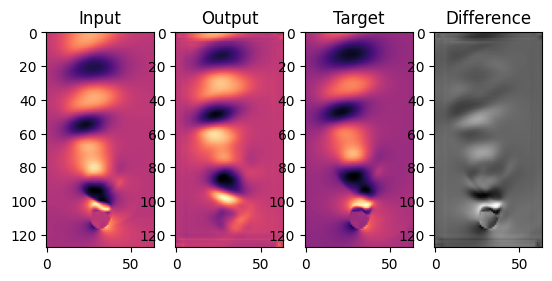

In [4]:
net.eval()

input, target = next(iter(loader))
output = net(input)

input = input.numpy()
target = target.numpy()
output = output.detach().numpy()

plt.subplot(1, 4, 1)
plt.imshow(np.flip(input[0, 1, ...], axis=-2), cmap="magma")
plt.title("Input")

plt.subplot(1, 4, 2)
plt.imshow(np.flip(output[0, 1, ...], axis=-2), cmap="magma")
plt.title("Output")

plt.subplot(1, 4, 3)
plt.imshow(np.flip(target[0, 1, ...], axis=-2), cmap="magma")
plt.title("Target")

diff = target[0, 1, ...] - output[0, 1, ...]
plt.subplot(1, 4, 4)
plt.imshow(np.flip(diff, axis=-2), cmap="gray")
plt.title("Difference")

plt.show()

# Comprehensive example: solver-in-the-loop

The following example shows how to conveniently integrate a solver into the training loop.

Notice that the dataset is initialized with the `intermediate_time_steps` flag. The dataset now not only supplies the initial and the target frame, but also all frames in between. This is necessary to compute the accumulated error over all time steps.

In [5]:
from pbdl.torch.phi.loader import Dataloader
from examples.ks.ks_networks import ConvResNet1D
from examples.ks.ks_solver import DifferentiableKS

# training parameters
BATCH_SIZE = 16
LR = 1e-4
EPOCHS = 4

# solver parameters
RES = 48
TIMESTEP = 0.5
DOMAIN_SIZE_BASE = 8
PREDHORZ = 5

device = "cuda:0" if torch.cuda.is_available() else "cpu"

diff_ks = DifferentiableKS(resolution=RES, dt=TIMESTEP)

# batch_sampler = ConstantBatchSampler(dataset, BATCH_SIZE, group_constants=[0]) # group after first constant
loader = Dataloader(
    "ks-dataset",
    PREDHORZ,
    step_size=20,
    intermediate_time_steps=True,
    normalize=False,
    batch_size=BATCH_SIZE,
    batch_by_const=[0],
    ret_batch_const=True,
)

net = ConvResNet1D(16, 3, device=device)
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
loss = torch.nn.MSELoss()

download completed	 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100%4m
Successfully loaded ks-dataset with 6 simulations and 259 samples each.
Prepare constant batch sampling...


The solver function `etd1` accepts only one domain size for each batch. This implies that the samples in a batch must have the same constants. The `ConstantBatchSampler` takes care of this, which is used by default by the loader of the `pbdl.torch.phi` module. The loader takes an argument `group_constants` which is passed to the `ConstantBatchSampler`. This argument lets you specify which constants should be considered for grouping into batches. When iterating over the batches in the training loop, the loader returns the non-normalized constants as third value, which apply to all samples in the batch.

When a solver is included in the training process, it is necessary to convert between PyTorch tensors and solver tensors and possibly add or remove constant layers. For this purpose, the dataset class from `pbdl.torch.phi` provides the auxiliary methods `to_phiflow` and `from_phiflow` to convert between tensor types and `cat_constants` to add constant layers to the solver output. `cat_constants` takes a reference tensor as input (second argument), from which it copies the constant layers. This is necessary, because the network output does not include the constant layers, which are required for the next iteration network input.

In [6]:
for epoch in range(EPOCHS):
    for i, (input, targets, const) in enumerate(loader):

        input = input.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        domain_size = const[0]

        inputs = [input]
        outputs = []

        for _ in range(PREDHORZ):
            output_solver = diff_ks.etd1(
                loader.to_phiflow(inputs[-1]), DOMAIN_SIZE_BASE * domain_size
            )

            correction = diff_ks.dt * net(inputs[-1])
            output_combined = loader.from_phiflow(output_solver) + correction

            outputs.append(output_combined)
            inputs.append(loader.cat_constants(outputs[-1], inputs[0]))

        outputs = torch.stack(outputs, axis=1)

        loss_value = loss(outputs, targets)
        loss_value.backward()
        optimizer.step()

    print(f"epoch { epoch }, loss {(loss_value.item()*10000.) :.3f}")

epoch 0, loss 853.284
epoch 1, loss 474.960
epoch 2, loss 292.121
epoch 3, loss 209.115


## Evaluation

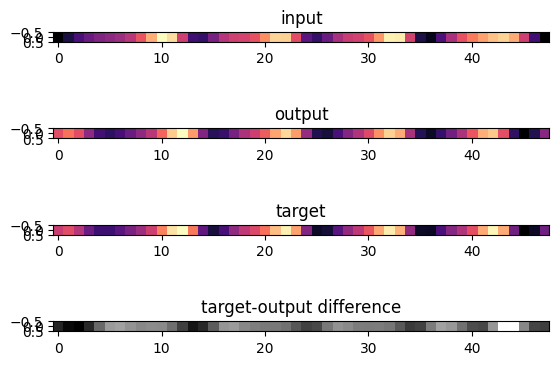

In [7]:
input, targets, _ = next(iter(loader))

domain_size = input[0][1][0].item()

inputs = [input]
outputs = []

for _ in range(PREDHORZ):
    output_solver = diff_ks.etd1(
        loader.to_phiflow(inputs[-1]), DOMAIN_SIZE_BASE * domain_size
    )
    output_combined = loader.from_phiflow(output_solver) + diff_ks.dt * net(inputs[-1])

    outputs.append(output_combined)
    inputs.append(loader.cat_constants(outputs[-1], inputs[0]))

outputs = torch.stack(outputs, axis=1)

input = inputs[0][0][0:1, ...].detach().numpy()
output = outputs[0][-1].detach().numpy()
target = targets[0][-1]

plt.subplot(4, 1, 1)
plt.imshow(input, cmap="magma", aspect=1)
plt.title("input")

plt.subplot(4, 1, 2)
plt.imshow(output, cmap="magma", aspect=1)
plt.title("output")

plt.subplot(4, 1, 3)
plt.imshow(target, cmap="magma", aspect=1)
plt.title("target")

diff = target - output
plt.subplot(4, 1, 4)
plt.imshow(diff, cmap="gray", aspect=1)
plt.title("target-output difference")

plt.show()

# Dataset files

A `.hdf5`-file is just a hierarchically structured collection of arrays (see [official documentation](https://docs.h5py.org/en/stable/quick.html)). For pbdl datasets, the hierarchy is very flat &ndash; there is just one group `sim/` containing all simulations (numpy arrays). These arrays are named `sim` concatenated with an incremental index. The `.hdf5` file format supports attaching metadata to arrays; for pbdl datasets this is used to store the constants.

Each simulation array has the shape `(frame, field, spatial dims...)`. The attached constant array has the shape `(const)`. The following code shows how to create the dataset file:

In [8]:
import numpy as np
import h5py

sim = np.zeros((1000, 3, 64, 32))
const = np.zeros((2))

with h5py.File("mydataset.hdf5", "w") as f:
    dset = f.create_dataset("sims/sim0", data=sim)
    dset.attrs["const"] = const

    # you can add more simulation array 'sims/sim1', 'sims/sim2', ...

# Local datasets

In the following example we will add a local dataset to the index, so it can be used with `Dataset`. First we need to generate a dataset (random array):

In [9]:
import os
import urllib
import h5py

# this is our directory for local datasets
os.makedirs(os.path.dirname("./local_datasets/"), exist_ok=True)

with h5py.File("./local_datasets/random_dataset.hdf5", "w") as f:
    for i in range(10): # generate 10 simulations

        random_data = np.random.rand(1000, 4, 64, 32)
        random_const = np.random.rand(3)

        dset = f.create_dataset("sims/sim" + str(i), data=random_data) # create hdf5 dataset
        dset.attrs["const"] = random_const # attach constants to dataset



The dataset class looks for datasets in two places: in the global index on the server and (if it exists) in the local index. The local index is a JSON file referenced by `local_index_path` in the config. Local datasets are expected to be in the directory specified by `local_datasets_dir` in the config. The following code creates such a file:

In [10]:
import json

data = {
    "random-dataset": {
        "path": "random_dataset.hdf5",
        "fields": "VVdp",
        "field_desc" : ["velocity x", "velocity y", "density", "pressure"],
        "const_desc" : ["constant 1", "constant 2", "constant 3"]
    }
}

with open("./local_datasets/datasets.json", "w") as file:
    json.dump(data, file, indent=4)

The local index file must have a specific structure:
- The path to your local `.hdf5`-file is specified by `path`. If the extension `.hdf5` is omitted the dataset is interpreted as a partitioned dataset. In this case, it is necessary to specify an additional attribute `num_part` for the number of partitions.
- `fields` contains information about the type of physical field in the form of a string, e.g. `VVdp`. Consecutive identical letters indicate that the physical field consists of the corresponding indices (`velocity x` and `velocity y` form a vector field because there are to consecutive `V`'s, `density` and `pressure` are scalar fields). This information affects how normalization is applied: For vector fields, the vector norm is applied first before the standard deviation is calculated.
- `field_desc`and `const_desc` contain descriptors for fields and constants.

Now that the local dataset is registered, we can use it:

In [11]:
from pbdl.loader import Dataloader

dataset = Dataloader(
    "random-dataset",
    10,
    local_index_path="./local_datasets/datasets.json", # overwrite config
    local_datasets_dir="./local_datasets/" # overwrite config
)

Successfully loaded random-dataset with 10 simulations and 990 samples each.
No precomputed normalization data found (or not complete). Calculating data...


# Config file

The config file is located in the same place where Python installs the package. It allows you to specify all static paths and looks something like this:

For convenience, all attributes in the configuration file can be overwritten by specifying the corresponding arguments when creating a `Datastset` instance.

In [12]:
dataset = Dataloader(
    "random-dataset",
    10,
    local_index_path="./local_datasets/datasets.json", # overwrite config
    local_datasets_dir="./local_datasets/" # overwrite config
)

Successfully loaded random-dataset with 10 simulations and 990 samples each.
